In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import pyfolio as pf

from scipy.stats import randint as sp_randint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

from utils import add_lag, add_diff

current_dir = os.getcwd()

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

pd.options.mode.chained_assignment = None  # default='warn'

/Users/danieloliveira/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
file = open(os.path.join(current_dir, "data", "new_fxmm.pickle"), 'rb')
target_dict = pickle.load(file)

fast_signals = target_dict["signals"]["fast"]
slow_signals = target_dict["signals"]["slow"]
bars = target_dict["bars"]

In [13]:
bkt_codes = list(bars.keys())
bar_name = "Close"
seed = 199402
init_step = 90
predict_step = 4
lags = 0
diff_lags = 0
param_distributions = {'C': np.linspace(0.001, 50, 200),
                       'l1_ratio': np.linspace(0.001, 0.999, 200)}
n_iter = 100
n_jobs = 6
n_splits = 5
ModelClass = LogisticRegression(fit_intercept=False, penalty='elasticnet', solver='saga', max_iter=1000)
time_split = TimeSeriesSplit(n_splits=n_splits)
roc_auc_scorer = make_scorer(roc_auc_score)

In [10]:
params = {}
aucs = {}
backtest = []
for bkt_code in bkt_codes:
    bar_df = bars[bkt_code][[bar_name]].resample("W-FRI").last()

    fast_signals_df = slow_signals[bkt_code]
    slow_signals_df = slow_signals[bkt_code]
    signals_df = ((fast_signals_df + slow_signals_df) / 2).ewm(span=5).mean().resample("W-FRI").last()
    
    if lags != 0:
        signals_df = add_lags(data=signals_df,
                              lags=lags)
        
    if diff_lags != 0:
        signals_df = add_diff(df=signals_df,
                              lags=diff_lags)

    y = bar_df[[bar_name]].pct_change().copy()
    X = signals_df.copy()

    data = pd.concat([y, X], axis=1).dropna()

    y_train = data[[bar_name]]
    y_train[bar_name] = [1 if r > 0 else 0 for r in y_train[bar_name]]
    X_train = data.drop(bar_name, axis=1)

    coefs = []
    results = []
    count = 1
    for i in tqdm(range(init_step, y_train.shape[0], predict_step),
                  total=((y_train.shape[0] - init_step) // predict_step),
                  desc="Rolling window CV: " + bkt_code):
        y_loop = y_train.iloc[0:i]
        X_loop = X_train.iloc[0:i]

        y_loop_test = y_train[bar_name].iloc[i:(i + predict_step)]
        X_loop_test = X_train.iloc[i:(i + predict_step)]

        model_search = RandomizedSearchCV(estimator=ModelClass,
                                          param_distributions=param_distributions,
                                          n_iter=n_iter,
                                          cv=time_split,
                                          verbose=False,
                                          n_jobs=n_jobs,
                                          scoring=roc_auc_scorer,
                                          random_state=seed)
        model_search = model_search.fit(X_loop.to_numpy(), y_loop.to_numpy().ravel())
        test_pred = model_search.best_estimator_.predict_proba(X_loop_test)[:, 1]
        dict_ = {"date": y_loop_test.index,
                 "return_direction": y_loop_test.values,
                 "prediction": test_pred}
        result = pd.DataFrame(dict_)
        results.append(result)
        
        coefs.append(pd.DataFrame(model_search.best_estimator_.coef_, columns=X_loop_test.columns, index=[y_loop_test.index[-1]]))

    results_df = pd.concat(results, axis=0).reset_index(drop=True)
    results_df.loc[results_df["prediction"] > 0.55, "prediction_class"] = 1
    results_df.loc[results_df["prediction"] < 0.45, "prediction_class"] = -1
    results_df.loc[(results_df["prediction"] >= 0.45) & (results_df["prediction"] <= 0.55), "prediction_class"] = 0
    results_df.set_index("date", inplace=True)

    tmp_backtest_df = pd.concat([bar_df.pct_change(), results_df[["prediction_class"]]], axis=1).dropna()
    tmp_backtest_df[bkt_code] = tmp_backtest_df["Close"] * tmp_backtest_df["prediction_class"]

    backtest.append(tmp_backtest_df[[bkt_code]])
    
    # calculate scores
    lr_auc = roc_auc_score(results_df["return_direction"], results_df["prediction"])
    aucs[bkt_code] = lr_auc
    
    coefs_df = pd.concat(coefs, axis=0)
    params[bkt_code] = coefs_df
backtest_df = pd.concat(backtest, axis=1)


Rolling window CV: USDZAR: 100%|██████████| 804/804 [03:32<00:00,  3.79it/s]


array([[<AxesSubplot:title={'center':'USDZAR'}>]], dtype=object)

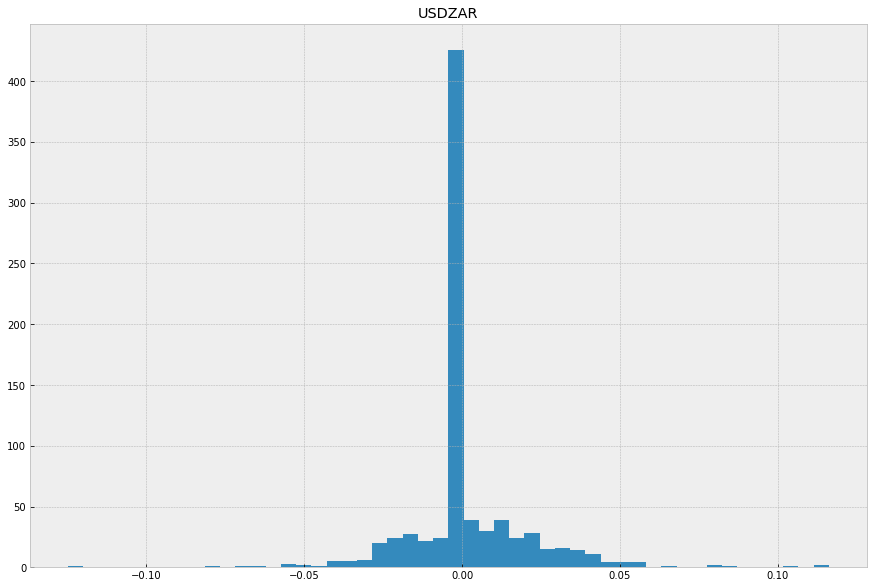

In [11]:
backtest_df.hist(bins=50)

Start date,2007-07-20
End date,2022-12-09
Total months,38
,Backtest
Annual return,67.7%
Cumulative returns,420.9%
Annual volatility,29.9%
Sharpe ratio,1.88
Calmar ratio,3.95
Stability,0.95
Max drawdown,-17.2%


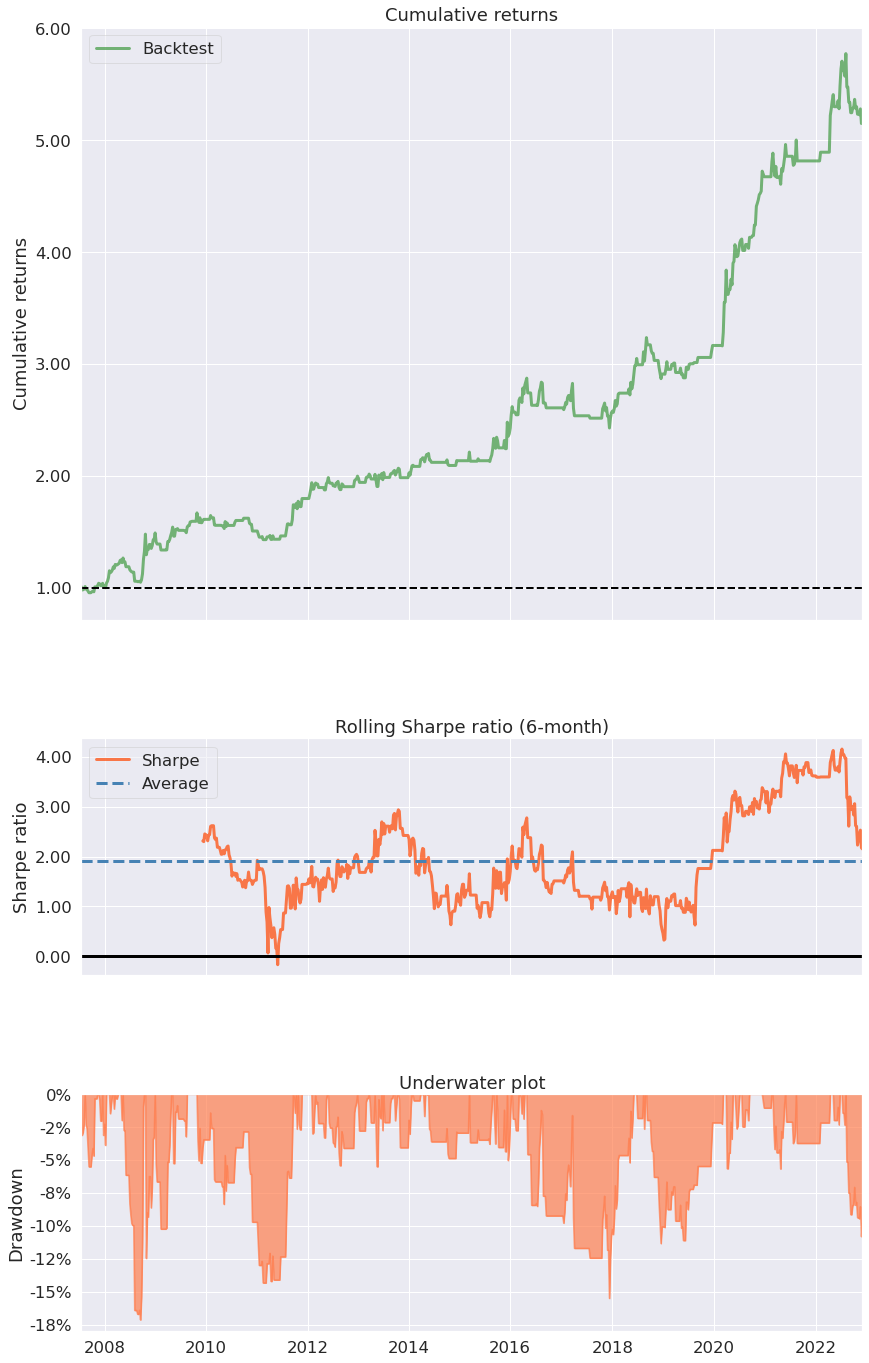

In [12]:
pf.create_simple_tear_sheet(backtest_df["USDZAR"])

In [13]:
{k: aucs[k] for k in sorted(aucs, key=aucs.get, reverse=True)}

{'USDZAR': 0.5685577952580472}

In [261]:
results_df = pd.concat(results, axis=0)
ns_probs = [0 for _ in range(len(results_df))]

In [262]:
results_df

,date,return_direction,prediction
0,2015-06-19,0.0,0.625564
0,2015-06-26,1.0,0.591277
0,2015-07-03,1.0,0.604876
0,2015-07-10,0.0,0.623544
0,2015-07-17,1.0,0.595329
...,...,...,...
0,2022-04-15,1.0,0.447180
0,2022-04-22,1.0,0.495530
0,2022-04-29,1.0,0.542925
0,2022-05-06,1.0,0.576722


In [18]:
# calculate scores
ns_auc = roc_auc_score(results_df["return_direction"], ns_probs)
lr_auc = roc_auc_score(results_df["return_direction"], results_df["prediction"])
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

NameError: name 'ns_probs' is not defined

In [19]:
ns_fpr, ns_tpr, _ = roc_curve(results_df["return_direction"], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(results_df["return_direction"], results_df["prediction"])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

NameError: name 'ns_probs' is not defined

In [20]:
results_df.loc[results_df["prediction"] > 0.5, "prediction_class"] = 1
results_df.loc[results_df["prediction"] < 0.5, "prediction_class"] = -1
results_df.set_index("date", inplace=True)

backtest_df = pd.concat([bar_df.pct_change(), results_df[["prediction_class"]]], axis=1).dropna()
backtest_df["returns"] = backtest_df["Close"] * backtest_df["prediction_class"]
(1 + backtest_df["returns"]).cumprod().plot()

KeyError: "None of ['date'] are in the columns"